In [21]:
import pickle
import itertools as itt
from scipy import stats
from statsmodels.stats.multitest import multipletests

In [40]:
from altProts_in_communities.utils import *

In [23]:
clusters_dict = pickle.load(open('clusters_dict.pkl', 'rb'))

In [24]:
with open('curated_gene_disease_associations.tsv', 'r') as f:
    disgenet = []
    for n,l in enumerate(f):
        ls = l.strip().split('\t')
        if n==0:
            keys=ls
            continue
        line = dict(zip(keys, ls))
        if float(line['score'])<=0.3:continue
        disgenet.append(line)
print(len(disgenet))

32375


In [25]:
n_genes = len(set(x['geneSymbol'] for x in disgenet))
n_diseases = len(set(x['diseaseName'] for x in disgenet))
n_assoc = len(disgenet)
print('Disgenet relates {} genes with {} diseases in {} associations.'.format(n_genes, n_diseases, n_assoc))

Disgenet relates 6970 genes with 8141 diseases in 32375 associations.


In [26]:
asso_scores = {((d['geneSymbol'], d['diseaseId'])):float(d['score']) for d in disgenet}

In [27]:
gene_diseases_ls = [(d['geneSymbol'], d['diseaseId'] , d['diseaseSemanticType'], d['diseaseClass'], d['diseaseName']) for d in disgenet]

diseaseid_diseasename = {}
for diseaseid, grp in itt.groupby(sorted(gene_diseases_ls, key=lambda x: x[1]), lambda x: x[1]):
    diseaseid_diseasename[diseaseid] = [x[4] for x in grp][0]
    
gene_diseases = {}
for gene, diseases in itt.groupby(sorted(gene_diseases_ls), lambda x: x[0]):
    gene_diseases[gene] = [x[1] for x in diseases]

disease_genes = {}
for disease, genes in itt.groupby(sorted(gene_diseases_ls, key=lambda x: x[1]), lambda x: x[1]):
    disease_genes[disease] = [x[0] for x in genes]

disease_types = {}
for disease, disease_grp in itt.groupby(sorted(gene_diseases_ls, key=lambda x: x[1]), lambda x: x[1]):
    distyp_set = set([x[2] for x in disease_grp])
    if len(distyp_set)>1:
        print(disease, distyp_set)
    disease_types[disease] = list(distyp_set)[0]

disease_classes = {}
for disease, disease_grp in itt.groupby(sorted(gene_diseases_ls, key=lambda x: x[1]), lambda x: x[1]):
    disclass_set = set(x for y in [x[3].split(';') for x in disease_grp] for x in y)
    disease_classes[disease] = disclass_set

# Contingency table
Fisher's exact test to verify wether disease genes are enriched in protein communities
(computed per disease for each community)
community genes, population genes
disease genes, 

null hypothesis: the cluster is not enriched in disease genes
alt  hypothesis: the cluster is enriched in disease genes

place all genes in contingency table:
                  in_clust              not_in_clust
    is_disease   intersect            non_comm disease genes
is_not_disease   non-disease comm     non-disease, non-comm genes

In [28]:
pop = set(x for y in [clust['graph'].nodes() for clust in clusters_dict.values()] for x in y if 'IP_' not in x)

In [29]:
clust_diseases = []
for clust_n, clust in clusters_dict.items():
    clust_genes = set(x for x in clust['graph'].nodes() if 'IP_' not in x and 'II_' not in x)
    non_clust_genes = pop - clust_genes
    assoc_diseases = set(x for y in [gene_diseases[x] for x in list(clust_genes) if x in gene_diseases] for x in y)
    for dis in assoc_diseases:
        dis_genes = set(disease_genes[dis])
        non_dis_genes = pop - dis_genes
        # Build a contingency table for each test
        cont_table = [[len(clust_genes.intersection(dis_genes)), len(dis_genes.difference(clust_genes))],
                      [len(clust_genes.difference(dis_genes)),   len(non_clust_genes.difference(dis_genes))]]
        odds_ratio, pval = stats.fisher_exact(cont_table, alternative='greater')
        # Run the test
        clust_diseases.append((clust_n, dis, odds_ratio, pval))

clust_diseases = sorted(clust_diseases, key=lambda x: x[-1])

clust_diseases_pvals = [x[-1] for x in clust_diseases]

fdr_bh = multipletests(clust_diseases_pvals, method='fdr_bh', alpha=0.01, is_sorted=True)
corrected_pvals = fdr_bh[1]
fdr_bh = fdr_bh[0]
sig_clust_diseases = list(itt.compress(clust_diseases, fdr_bh))

n_dieases = len(set(x[1] for x in sig_clust_diseases))
n_clust   = len(set(x[0] for x in sig_clust_diseases))
n_clust_alt = sum([clusters_dict[x]['contains_alt'] for x in list(set(x[0] for x in sig_clust_diseases))])
print('{} clusters of which {} contain at least one altProt are found in association with {} diseases in {} cluster-disease associations.'.format(
    n_clust, n_clust_alt, n_dieases, len(sig_clust_diseases)))

687 clusters of which 93 contain at least one altProt are found in association with 2612 diseases in 2743 cluster-disease associations.


In [30]:
for clust_n, diseases in itt.groupby(sorted(sig_clust_diseases), key=lambda x: x[0]):
    clusters_dict[clust_n]['diseases'] = [x[1:] for x in diseases]

for clust_n, clust in clusters_dict.items():
    if clust['contains_alt'] and 'diseases' in clust:
        clust['disease_gene_counts'] = {}
        for dis in clust['diseases']:
            clust['disease_gene_counts'][dis[0]] = set.intersection(set(clusters_dict[clust_n]['graph'].nodes()), set(disease_genes[dis[0]]))

In [61]:
# clusters-GO-diseases expanded view table
import csv
def remove_altgene(edge):
    edge = [node.split('|')[0] for node in edge]
    return edge
cols = ('cluster number', 'PPIs (edges)', 'GOterm_pval', 'disease_pval')
with open('bioplex_tables/Table_EV5.tsv', 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerow(cols)
    for clust_n, clust in clusters_dict.items():
        clust_name = '#{}'.format(clust_n)
        edges = '|'.join(['-'.join(remove_altgene(e)) for e in clust['graph'].edges()])
        
        row = [clust_name, edges, ]
        writer.writerow(row)

In [31]:
# MeSh
mesh = "Infections [C01];\
Neoplasms [C04];\
Musculoskeletal Diseases [C05];\
Digestive System Diseases [C06];\
Stomatognathic Diseases [C07];\
Respiratory Tract Diseases [C08];\
Otorhinolaryngologic Diseases [C09];\
Nervous System Diseases [C10];\
Eye Diseases [C11];\
Male Urogenital Diseases [C12];\
Female Urogenital Diseases and Pregnancy Complications [C13];\
Cardiovascular Diseases [C14];\
Hemic and Lymphatic Diseases [C15];\
Congenital, Hereditary, and Neonatal Diseases and Abnormalities [C16];\
Skin and Connective Tissue Diseases [C17];\
Nutritional and Metabolic Diseases [C18];\
Endocrine System Diseases [C19];\
Immune System Diseases [C20];\
Disorders of Environmental Origin [C21];\
Animal Diseases [C22];\
Pathological Conditions, Signs and Symptoms [C23];\
Occupational Diseases [C24];\
Chemically-Induced Disorders [C25];\
Wounds and Injuries [C26];\
Behavior and Behavior Mechanisms [F01];\
Psychological Phenomena [F02];\
Mental Disorders [F03] "

mesh = [[x.strip().replace(']','') for x in m.split('[')] for m in mesh.split(';')]

mesh_dict = {x[1]:x[0] for x in mesh}

In [32]:
dis_classes = list(mesh_dict.keys())

In [33]:
dis_class_summary = {d:{'alt_clust':0, 'no_alt_clust':0} for d in dis_classes}
for dis_class in dis_classes:
    for clust_n, diseaseid, OR, pval in sig_clust_diseases:
        if dis_class in disease_classes[diseaseid]:
            if clusters_dict[clust_n]['contains_alt']:
                dis_class_summary[dis_class]['alt_clust'] += 1
            else:
                dis_class_summary[dis_class]['no_alt_clust'] += 1

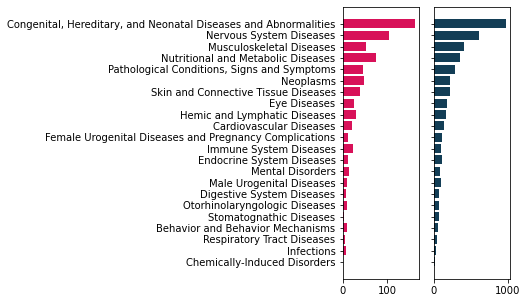

In [34]:
fig, axs = plt.subplots(1,2,figsize=(3,5), sharey=True, facecolor='w')
height=0.8
disclasses, alt_cnts, no_alt_cnts, alt_percent = \
list(zip(*sorted([(k, v['alt_clust'], v['no_alt_clust'], 100*v['alt_clust']/(v['alt_clust']+v['no_alt_clust'])) for k,v in dis_class_summary.items() if  v['alt_clust']+v['no_alt_clust']>10], key=lambda x: sum(x[1:3]))))
axs[0].barh([mesh_dict[d] for d in disclasses], alt_cnts, color='#d81159', height=height)

#plt.xticks([5, 10, 15, 20])
axs[1].barh([mesh_dict[d] for d in disclasses], no_alt_cnts, color='#133e56', height=height)
#plt.xticks([0, 500, 1000, 1500])
plt.savefig('bioplex_figures/disease_counts_bar.svg')
plt.show()

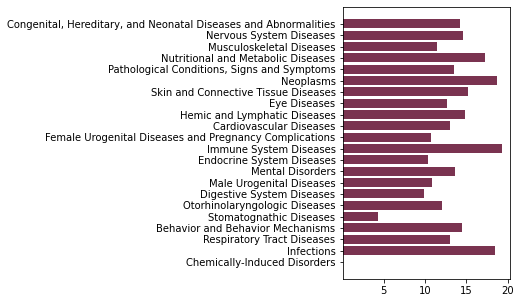

In [35]:
fig, ax = plt.subplots(figsize=(3,5))
disclasses, alt_percent, alt_clust, alt_no_clust = \
list(zip(*sorted([(k, 100*v['alt_clust']/(v['no_alt_clust']+v['alt_clust']), v['alt_clust'], v['no_alt_clust']) for k,v in dis_class_summary.items() if  v['alt_clust']+v['no_alt_clust']>10], key=lambda x: sum(x[2:]))))
ax.barh([mesh_dict[d] for d in disclasses], alt_percent, color='#7a3350', height=height)
plt.xticks([5, 10, 15, 20])
plt.savefig('bioplex_figures/disease_ratio_bar.svg')
plt.show()

In [41]:
HCIP_baits = pickle.load(open('HCIP_baits.pkl', 'rb'))

def tt_type_node_attrs(G, HCIP_baits):    
    node_attrs = {}
    for n in G.nodes():
        node_attrs[n] = {}
        if is_alt(n):
            node_attrs[n]['tt_type'] = 'alt'
            node_attrs[n]['node_type'] = 'prey'
        else:
            node_attrs[n]['tt_type'] = 'ref'
            if n in HCIP_baits:
                node_attrs[n]['node_type'] = 'bait'
            else:
                node_attrs[n]['node_type'] = 'prey'

    return node_attrs

In [51]:
diseaseid_diseasename['C0079744']

'Diffuse Large B-Cell Lymphoma'

In [53]:
for clust_n, clust in clusters_dict.items():
    if not clust['contains_alt']: continue
    if not 'diseases' in clust: continue
    print(clust_n, clust['alts'])
    for disease, genes in clust['disease_gene_counts'].items():
        print('\t', len(genes), diseaseid_diseasename[disease], genes)
    

42 ['EIF3LP2|IP_790907', 'EIF4A1P7|IP_758374']
	 1 PARKINSON DISEASE 18 {'EIF4G1'}
	 1 INTELLECTUAL DEVELOPMENTAL DISORDER, AUTOSOMAL RECESSIVE 67 {'EIF3F'}
43 ['ALPK3|IP_236856']
	 2 Rubinstein-Taybi Syndrome {'CREBBP', 'EP300'}
	 3 Diffuse Large B-Cell Lymphoma {'SKP2', 'CREBBP', 'EP300'}
	 1 RUBINSTEIN-TAYBI SYNDROME 2 {'EP300'}
	 1 MEIER-GORLIN SYNDROME 4 {'CDT1'}
	 2 RUBINSTEIN-TAYBI SYNDROME 1 {'CREBBP', 'EP300'}
	 1 INTELLECTUAL DEVELOPMENTAL DISORDER AND RETINITIS PIGMENTOSA {'SCAPER'}
50 ['SLC38A10|IP_711690']
	 1 Insulin-dependent diabetes mellitus secretory diarrhea syndrome {'FOXP3'}
	 1 Apraxia, Verbal {'FOXP2'}
	 1 Apraxia, Oral {'FOXP2'}
	 1 Specific language impairment {'FOXP2'}
	 1 Microcephaly, Primary Autosomal Recessive, 6 {'CENPJ'}
	 1 Combined Oxidative Phosphorylation Deficiency 3 {'TSFM'}
	 1 PERRAULT SYNDROME 2 {'HARS2'}
	 1 SECKEL SYNDROME 4 {'CENPJ'}
51 ['CEPT1|IP_679545']
	 1 Marden Walker like syndrome {'SCARF2'}
	 1 SURFACTANT METABOLISM DYSFUNCTION, PULMO

	 1 THROMBOPHILIA DUE TO PROTEIN S DEFICIENCY, AUTOSOMAL RECESSIVE {'PROS1'}
649 ['GATB|IP_618814']
	 1 Mitochondrial cardiomyopathy {'QRSL1'}
653 ['TUBB8P5|IP_762158']
	 1 Growth retardation, Alopecia, Pseudoanodontia and Optic atrophy {'ANTXR1'}
	 1 Cortisone reductase deficiency {'H6PD'}
	 1 HEMANGIOMA, CAPILLARY INFANTILE {'ANTXR1'}
	 1 CORTISONE REDUCTASE DEFICIENCY 1 {'H6PD'}
663 ['GLB1|IP_101889']
	 1 Mucopolysaccharidosis IV {'GLB1'}
	 1 Gangliosidosis GM1 {'GLB1'}
	 1 Mucopolysaccharidosis, MPS-IV-A {'GLB1'}
	 1 Mucopolysaccharidosis type IVB {'GLB1'}
	 1 GALACTOSIALIDOSIS {'CTSA'}
	 1 Gangliosidosis, Generalized GM1, Type 1 (disorder) {'GLB1'}
	 1 Gangliosidosis, Generalized GM1, Type 2 {'GLB1'}
	 1 Gangliosidosis, Generalized GM1, Type 3 {'GLB1'}
	 1 beta-Galactosidase Deficiency {'GLB1'}
	 1 Familial hypertryptophanemia {'TDO2'}
	 1 GALNS Deficiency {'GLB1'}
682 ['ITGB8|IP_150650']
	 1 Long chain acyl-CoA dehydrogenase deficiency {'ACADL'}
	 1 MYASTHENIC SYNDROME, CONGENITA

In [55]:
plt.rcParams['svg.fonttype'] = 'none'

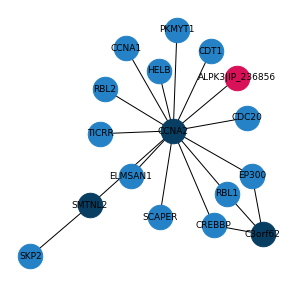

In [56]:
node_size = 600
margin = 0.1
clust_n = 43
G_neig = clusters_dict[clust_n]['graph']
nx.set_node_attributes(G_neig, tt_type_node_attrs(G_neig, HCIP_baits))
file_name, legend = get_graph_vis(
                G_neig, '{}'.format(clust_n), figsize=(5,5),
                node_size=node_size,
                alt_node_size=node_size,
                layout_params={'k':0.1, 'iterations':50},
                file_name='cluster#{}.svg'.format(clust_n),
                file_path='bioplex_figures/subnets/',
                draw_labels=True,
                margin=margin,
        )

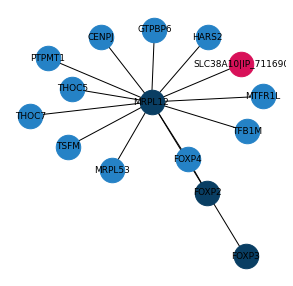

In [58]:
node_size = 600
margin = 0.1
clust_n = 50
G_neig = clusters_dict[clust_n]['graph']
nx.set_node_attributes(G_neig, tt_type_node_attrs(G_neig, HCIP_baits))
file_name, legend = get_graph_vis(
                G_neig, '{}'.format(clust_n), figsize=(5,5),
                node_size=node_size,
                alt_node_size=node_size,
                layout_params={'k':0.1, 'iterations':50},
                file_name='cluster#{}.svg'.format(clust_n),
                file_path='bioplex_figures/subnets/',
                draw_labels=True,
                margin=margin,
        )

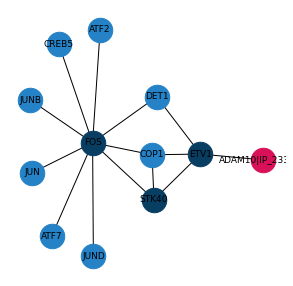

In [59]:
node_size = 600
margin = 0.1
clust_n = 78
G_neig = clusters_dict[clust_n]['graph']
nx.set_node_attributes(G_neig, tt_type_node_attrs(G_neig, HCIP_baits))
file_name, legend = get_graph_vis(
                G_neig, '{}'.format(clust_n), figsize=(5,5),
                node_size=node_size,
                alt_node_size=node_size,
                layout_params={'k':0.1, 'iterations':50},
                file_name='cluster#{}.svg'.format(clust_n),
                file_path='bioplex_figures/subnets/',
                draw_labels=True,
                margin=margin,
        )